<img src="https://upload.wikimedia.org/wikipedia/en/a/a1/Visma_logo.jpg"
     align="right"
     width="30%"
     alt="Visma logo">

Classification Workflow 
=============

<img src="http://www.rm.dk/siteassets/regional-udvikling/digitalisering/dabai/dabai-logo.png"
     align="right"
     width="20%"
     alt="DABAI logo">
     
The following notebook shows how the workflow for classification should be executed.

In [1]:
import sys, getpass, os
from IPython import display

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
print(module_path)

/home/svanhmic/workspace/DABAI/Workflows


In [2]:
user = getpass.getuser()
if user == "sidsel":
    parquet_path = "/home/sidsel/workspace/sparkdata/parquet"
elif user == "svanhmic":
    parquet_path = "/home/svanhmic/workspace/data/DABAI/sparkdata/parquet"
    
#csv_str = '/home/svanhmic/workspace/data/DABAI/test.csv'
#file_str = '/home/svanhmic/workspace/data/DABAI/test.txt'
#parquet_str = '/home/svanhmic/workspace/data/DABAI/sparkdata/parquet/alleregnskaber.parquet'
#json_str = '/home/svanhmic/workspace/data/DABAI/sparkdata/json/cdata-permanent.json'


In [3]:
from classification.ExecuteClassificationWorkflow import ExecuteWorkflowClassification
import classification.CreateParametersClasification as create_params

from shared import GeneralDataImport

In [4]:
selector = create_params.ParamsClassification()
params = selector.select_parameters()
display.display(params)

In [5]:
parameter_dict = selector.output_parameters(params)
parameter_dict

{'algorithm': 'LogisticRegression',
 'elasticNetParam': (0.0, 0.5),
 'fitIntercept': True,
 'labelCol': 'label',
 'maxIter': (100, 150),
 'predictionCol': 'prediction',
 'probabilityCol': 'probability',
 'rawPredictionCol': 'rawPrediction',
 'regParam': (0.0, 0.5),
 'threshold': (0.0, 0.5),
 'tol': (1e-06, 0.01)}

In [6]:
data_import = GeneralDataImport.GeneralDataImport(parquet_path+'/normal_cluster_n_10000.parquet')

In [7]:
data_import.select_columns()

In [8]:
from pyspark.sql import functions as F

train_df, test_df = (data_import.data_frame.withColumn('label', F.when(F.randn()>=0.5,1.0).otherwise(0)).randomSplit([3.0,1.0]))
            
train_df.show(3)

print(data_import.list_features)
print(train_df.count())

+---+---+---------+------------------+------------------+-----+
| id|  k|dimension|                 a|                 b|label|
+---+---+---------+------------------+------------------+-----+
|  0|  4|        2|6.9872319773728275|1.2750762113727783|  0.0|
|  0|  5|        2|  -2.8433028165902|-6.868296778115026|  0.0|
|  0|  6|        2| 4.441651704259621|-3.472884978939291|  1.0|
+---+---+---------+------------------+------------------+-----+
only showing top 3 rows

[StructField(a,DoubleType,true), StructField(b,DoubleType,true)]
7507


In [12]:
model = ExecuteWorkflowClassification(
    parameter_dict,
    data_import.standardize,
    data_import.list_features
)

In [13]:
len(model.parameter_grid)

243

In [14]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
result_model = model.pipeline.fit(train_df)
crossfitted_model = model.run_cross_val(train_df,BinaryClassificationEvaluator(),10)
#summary = fitted_data.bestModel.stages[-1].summary

In [15]:
result_df = result_model.transform(test_df)
result_df.limit(5).toPandas()

,id,k,dimension,a,b,label,vectorized_features,scaled,rawPrediction,probability,prediction
0,0,7,2,-4.273084,-1.654403,0.0,"[-4.273083948, -1.65440270399]","[-4.273083948, -1.65440270399]","[0.955771889063, -0.955771889063]","[0.722274468773, 0.277725531227]",0.0
1,1,4,2,7.455648,-1.079207,0.0,"[7.4556484386, -1.07920738165]","[7.4556484386, -1.07920738165]","[0.741554763447, -0.741554763447]","[0.677335746595, 0.322664253405]",0.0
2,10,7,2,-3.238991,0.957753,0.0,"[-3.23899134917, 0.957753445337]","[-3.23899134917, 0.957753445337]","[0.922873460057, -0.922873460057]","[0.715627231033, 0.284372768967]",0.0
3,100,6,2,6.917132,0.368509,1.0,"[6.91713204966, 0.368508966777]","[6.91713204966, 0.368508966777]","[0.743326715301, -0.743326715301]","[0.677722888522, 0.322277111478]",0.0
4,100,7,2,-2.119901,0.036986,0.0,"[-2.11990143841, 0.0369863616085]","[-2.11990143841, 0.0369863616085]","[0.907770998477, -0.907770998477]","[0.712543823626, 0.287456176374]",0.0


In [16]:
(crossfitted_model
 .transform(test_df)
 .drop('vectorized_features')
 .drop('scaled')
 .limit(20)
 .toPandas())

,id,k,dimension,a,b,label,rawPrediction,probability,prediction
0,0,7,2,-4.273084,-1.654403,0.0,"[0.941898605943, -0.941898605943]","[0.719483007387, 0.280516992613]",1.0
1,1,4,2,7.455648,-1.079207,0.0,"[0.743097423244, -0.743097423244]","[0.677672805754, 0.322327194246]",1.0
2,10,7,2,-3.238991,0.957753,0.0,"[0.903862467932, -0.903862467932]","[0.711742593787, 0.288257406213]",1.0
3,100,6,2,6.917132,0.368509,1.0,"[0.740422560731, -0.740422560731]","[0.677088251724, 0.322911748276]",1.0
4,100,7,2,-2.119901,0.036986,0.0,"[0.892705564583, -0.892705564583]","[0.709448190406, 0.290551809594]",1.0
5,1000,6,2,5.347565,-2.849655,0.0,"[0.792176725465, -0.792176725465]","[0.688298524549, 0.311701475451]",1.0
6,1001,5,2,-4.822004,-8.002406,0.0,"[1.00181289112, -1.00181289112]","[0.731414865317, 0.268585134683]",1.0
7,1002,6,2,7.571864,-2.121754,0.0,"[0.74952041605, -0.74952041605]","[0.679074191255, 0.320925808745]",1.0
8,1005,5,2,-3.233244,-6.387497,0.0,"[0.962577494981, -0.962577494981]","[0.723637565664, 0.276362434336]",1.0
9,1006,5,2,-3.563202,-7.498639,0.0,"[0.976937127226, -0.976937127226]","[0.726500052869, 0.273499947131]",1.0


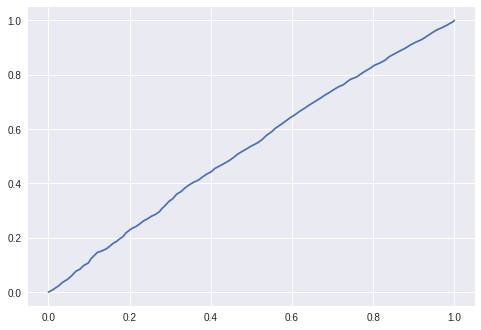

In [17]:
#crossfitted_model.avgMetrics
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


best_lr = crossfitted_model.bestModel.stages[-1]
best_pdf = best_lr.summary.roc.toPandas()
sb.set_style("darkgrid")
plt.plot(best_pdf['FPR'],best_pdf['TPR'])
plt.show()
